EvoDev iteration 2 --

Mask a certain percent of the context so information leak is not possible.

Loss function will only evaluate masked tokens, which means the model will evolve slower.

One possibility is to let a small number of non-masked tokens learn as well since it probably won't cheat.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import random

from google.colab import files

In [ ]:
# hyperparameters
batch_size = 64
block_size = 127
n_embd = 240
n_head = 6
n_layer = 6
dropout = 0.1
mask_percent = 0.15
vocab_size = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_iters = 20000
switch_iter = 16000
eval_interval = 100
learning_rate = 3e-4

eval_iters = 200
# ------------

random.seed(1335)
torch.manual_seed(1337);

torch.set_default_device(device)

In [ ]:
#uploaded = files.upload()

file_name = "clc_data.fasta"
file_name_aligned = "meth1_aln-d.fasta"

with open(file_name, "r") as f:
    lines = f.readlines()

# get dictionary of sequences and names associated with them
seq_dict = {}
name, seq = None, None
for line in lines:
    if line.startswith(">"):
        if not name is None:
            seq_dict[name] = "." + seq + "."
        name = line.strip()[1:]
        seq = ""
    else:
        seq += line.strip()
seq_dict[name] = "." + seq + "." # last name:seq pair

sequences = seq_dict.values()
text = [char for string in sequences for char in string]

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
chars.append('_') # include the mask symbol

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(chars)

['.', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '_']


In [ ]:
# Train and test splits
data = [torch.tensor(encode(seq),dtype=torch.long) for seq in sequences]
#data = torch.tensor(encode(sequences), dtype=torch.long)
shuffle = list(range(len(data)))
random.shuffle(shuffle)
data_shuf = [data[i] for i in shuffle]
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data_shuf[:n]
val_data = data_shuf[n:]

In [ ]:
print(len(train_data))
print(len(val_data))

20773
2309


In [ ]:
# for each batch, x is a sequence of length (block_size + 1) that is randomly masked
# y is the answer for each masked_token, length: # of masked tokens = int(mask_percent*(block_size+1))
def get_batch(split):
    data = train_data if split == 'train' else val_data
    seqs = torch.randint(len(data), (batch_size,))
    x = []
    y = []
    masked_idx = torch.tensor(sorted(torch.randperm(block_size+1)[:int(mask_percent*(block_size+1))]))
    for seq in seqs:
        i = torch.randint(len(data[seq]) - block_size - 1, (1,)).item() # -1 since x will be of length (block_size + 1)
        sample = data[seq][i:i+block_size+1].clone()
        y.append(sample[masked_idx])
        sample[masked_idx] = encode('_')[0] # mask the masked_idx
        x.append(sample)
    return torch.stack(x), torch.stack(y)

@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

@torch.no_grad()
def estimate_accuracy():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = m(X)

        correct = 0
        total = 0

    m.train()
    return out

In [ ]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.ffwd = FeedForward(n_embd, dropout=dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn_weights = None # for visualization of attention
        # no attention mask necessary

    def forward(self, x):
        B, T, C = x.shape
        x1 = self.ln1(x)
        #x = x + self.sa(x1, x1, x1)[0]
        attn_output, self.attn_weights = self.sa(x1, x1, x1)
        x = x + attn_output
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
# evolution model with transformer architecture
class EvoModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # eventually replace with bigram model
        self.position_embedding_table = nn.Embedding(block_size + 1, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx is (B,T) tensor of integers
        # targets is (B, int(mask_percent*(block_size+1)))
        mask_tokens = torch.tensor([encode("_")] * B).reshape(B, 1)
        inp = torch.cat([mask_tokens, idx[:, :-1]], dim=1)
        tok_emb = self.token_embedding_table(inp) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)

        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            _, T2 = targets.shape
            logits = logits.view(B*T, C)
            idx = idx.view(B*T) # or just flatten
            masked_idx = torch.nonzero(idx == encode('_')[0], as_tuple=True)[0] # pick out masked indices from idx
            targets = targets.view(B*T2)

            loss = F.cross_entropy(logits[masked_idx], targets) # only include logits for tokens originally masked

        return logits, loss

    @torch.no_grad() # ONLY FOR EVALUATION
    def predict_proba(self, s, res):
        self.eval()
        if s[0] == ".": # check to see if seed is encoded yet
            seed = s
            seed = encode(seed)
        else:
            seed = s.copy()

        seed[res] = encode("_")[0] # mask the residue of interest
        inp = []
        t = []
        for i in range(max(res-block_size, 0), min(res, len(seed)-block_size-1)):
            inp.append(torch.tensor(seed[i:i+block_size+1], dtype=torch.long, device=device))
            t.append(res-i) # might need to edit this

        out, _ = self(torch.stack(inp))

        logits = []
        for i in range(len(inp)):
            logits.append(out[i,t[i],:])
        logits = torch.stack(logits)

        probs = F.softmax(logits,dim=-1)
        self.train()
        return probs.mean(dim=0) # shape = (vocab_size,)

In [ ]:
model = EvoModel()
m = model.to(device)
# m = torch.compile(m)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.212512 M parameters


In [ ]:
m.load_state_dict(torch.load('model_nov29.pth'))

<ipython-input-24-623ef0511ac4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load('model_nov29.pth'))


<All keys matched successfully>

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter == switch_iter:
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate * 0.10
            print("Learning Rate is now", learning_rate * 0.10)
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 

In [ ]:
#torch.save(m.state_dict(), 'model_nov29.pth')

losses = estimate_loss()
print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

In [ ]:
# returns tensor of shape (len(seed), vocab_size)
# probability distribution for every residue
def get_probs(seed):
    seed = encode(seed)
    return torch.stack([m.predict_proba(seed, res) for res in range(1, len(seed)-1)])

def get_accuracy(seed):
    correct = 0
    total = 0
    for res in range(1, len(seed)-1):
        predict = torch.argmax(m.predict_proba(seed, res))
        if predict == encode(seed[res])[0]:
            correct += 1
        total += 1
    return correct/total

# generate from the model
def mutate(seed, max_iters):
    seed = encode(seed)
    mutations = 0
    for iter in range(max_iters):
        if iter % 50 == 0:
            print(">gen" + str(iter))
            print(decode(seed)[1:-1] + "\n")

        res = random.randint(1, len(seed)-2)
        total = m.predict_proba(seed, res)
        idx_next = torch.multinomial(total, num_samples=1).item()
        if idx_next != seed[res]:
            mutations += 1

        seed[res] = idx_next

    print(">gen" + str(max_iters))
    print(decode(seed)[1:-1] + "\n")
    return mutations


In [ ]:
sum = 0
count = 0
for seq in val_data[:100]:
    seq = seq.tolist()
    val = get_accuracy(decode(seq))
    print(val)
    sum += val
    count += 1
print(sum/count)

In [ ]:
#mutate(seq_dict["uv0000P76175"], 1000)

In [ ]:
mutate(seq_dict["uv0000P37019"], 1)

>gen0
MKTDTPSLETPQAARLRRRQLIRQLLERDKTPLAILFMAAVVGTLVGLAAVAFDKGVAWLQNQRMGALVHTADNYPLLLTVAFLCSAVLAMFGYFLVRKYAPEAGGSGIPEIEGALEDQRPVRWWRVLPVKFFGGLGTLGGGMVLGREGPTVQIGGNIGRMVLDIFRLKGDEARHTLLATGAAAGLAAAFNAPLAGILFIIEEMRPQFRYTLISIKAVFIGVIMSTIMYRIFNHEVALIDVGKLSDAPLNTLWLYLILGIIFGIFGPIFNKWVLGMQDLLHRVHGGNITKWVLMGGAIGGLCGLLGFVAPATSGGGFNLIPIATAGNFSMGMLVFIFVARVITTLLCFSSGAPGGIFAPMLALGTVLGTAFGMVAVELFPQYHLEAGTFAIAGMGALLAASIRAPLTGIILVLEMTDNYQLILPMIITGLGATLLAQFTGGKPLYSAILARTLAKQEAEQLARSKAASASENT

>gen1
MKTDTPSLETPQAARLRRRQLIRQLLERDKTPLAILFMAAVVGTLVGLAAVAFDKGVAWLQNQRMGALVHTADNYPLLLTVAFLCSAVLAMFGYFLVRKYAPEAGGSGIPEIEGALEDQRPVRWWRVLPVKFFGGLGTLGGGMVLGREGPTVQIGGNIGRMVLDIFRLKGDEARHTLLATGAAAGLAAAFNAPLAGILFIIEEMRPQFRYTLISIKAVFIGVIMSTIMYRIFNHEVALIDVGKLSDAPLNTLWLYLILGIIFGIFGPIFNKWVLGMQDLLHRVHGGNITKWVLMGGAIGGLCGLLGFVAPATSGGGFNLIPIATAGNFSMGMLVFIFVARVITTLLCFSSGAPGGIFAPMLALGTVLGTAFGMVAVELFPQIHLEAGTFAIAGMGALLAASIRAPLTGIILVLEMTDNYQLILPMIITGLGATLLAQFTGGKPLYSAILARTLAKQEAEQLARSKAASASENT



1

In [ ]:
#mutate(seq_dict["uv0000P67729"], 1000)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

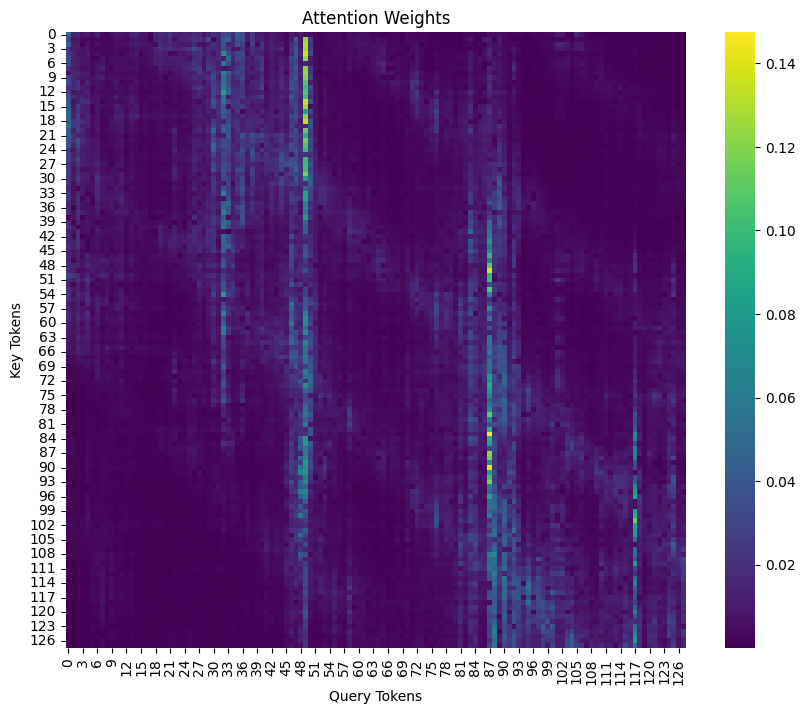

In [ ]:
seed = encode(seq_dict["uv0000P37019"])

logits = m(torch.unsqueeze(torch.tensor(seed[100:228], dtype=torch.long, device=device), 0))
attn_weights = m.blocks[2].attn_weights[0]

# Assuming attn_weights is a (sequence_length, sequence_length) tensor
plt.figure(figsize=(10, 8))
sns.heatmap(attn_weights.detach().cpu().numpy(), cmap="viridis", annot=False)
plt.xlabel("Query Tokens")
plt.ylabel("Key Tokens")
plt.title("Attention Weights")
plt.show()